[Prophet Toolbox Documentation](https://facebook.github.io/prophet/docs/saturating_forecasts.html)

# Import

## Path

In [1]:
import os
import sys

p = os.path.abspath('../')
if p not in sys.path:
    print('Adding {} path to system'.format(p))
    sys.path.append(p)
    


Adding C:\Cerebral\_MarioSandBox\Python\projectPage_myOntarioCovidModelTrendAnalysis\git_projectCodes\myOntarioCovidModelTrendAnalysis path to system


The [Epidemiological Data from the COVID-19 Outbreak in Canada](https://github.com/ishaberry/Covid19Canada) located in github.



In [2]:
import plotly# Complete Database
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Modules

In [3]:
from myFunctions.covid import covid as cvd
import myFunctions.myVis as myVis
import myFunctions.mySEWIRM as mySIWIRMModel
import myFunctions.mySDIR as mySDIRModel

In [4]:
import pandas as pd
import numpy as np

In [5]:
from utilities.EpiModel import *
import utilities.PDEparams as pde
from scipy.integrate import odeint

In [6]:
from scipy.integrate import solve_ivp
import optuna
optuna.logging.disable_default_handler()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import timedelta

# Modeling Functions

In [7]:
def getPop(province='Ontario',p='C:\Cerebral\_MarioSandBox\Python\projectPage_myOntarioCovidModelTrendAnalysis\git_projectCodes\myOntarioCovidModelTrendAnalysis'):
    provinceDataPopFile = '\data\provincePop.csv'
    popData = pd.read_csv(p + provinceDataPopFile)
    popData = popData.set_index('province')    
    return popData.loc[province].population

# Get Data

In [8]:
covidObject = cvd(cached=True)

Getting COVID data
cached


In [9]:
provToAnalyze = 'Ontario'
covidObject.getProcessedData(provToAnalyze)

In [10]:
# convert dictionary into dataframe
dfData = pd.DataFrame.from_dict(covidObject.dataProcess)
# convert date col to datetime pandas series
dfData['date'] = pd.to_datetime(dfData['date'])
# convert index to dates
dfData = dfData.set_index('date')

In [11]:
dfData.tail()

,contracted,mortality,recovered,testing
date,,,,
2020-04-21,12706,697,5806,174170
2020-04-22,13418,757,6221,184531
2020-04-23,13996,798,6680,194745
2020-04-24,14487,851,7087,207040
2020-04-25,14915,899,7509,217618


In [12]:
provPop = getPop('Ontario')

# Trend Analysis

### Contracted

From the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-05 (25)    | 2020-03-20 (40)  |
| 2     | 2020-03-20 (40)    | 2020-04-04 (55)  |
| 3     | 2020-04-04 (55)    | today (:)        |

In [13]:
phase = [1,2,3]
phaseStart = [25,40,55]
phaseEnd = [40,55,len(dfData)]

critPhaseCases = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseCases.append(dictPhase)

# Modeling SIRM

In [14]:
critPhaseCases

[{'phase': 1, 'phaseStart': 25, 'phaseEnd': 40},
 {'phase': 2, 'phaseStart': 40, 'phaseEnd': 55},
 {'phase': 3, 'phaseStart': 55, 'phaseEnd': 77}]

In [15]:
dfData.tail()

,contracted,mortality,recovered,testing
date,,,,
2020-04-21,12706,697,5806,174170
2020-04-22,13418,757,6221,184531
2020-04-23,13996,798,6680,194745
2020-04-24,14487,851,7087,207040
2020-04-25,14915,899,7509,217618


## Estimation

Now analyzing phase 1
    $beta1$   $beta2$   $beta3$  $alpha1$   $gamma$  $alpha2$
0  0.301482  1.996154  0.135138   0.19949  0.016301  0.101265
Now analyzing phase 2
    $beta1$   $beta2$   $beta3$  $alpha1$   $gamma$  $alpha2$
0  0.305952  1.986575  0.134789  0.199762  0.023586  0.108991
Now analyzing phase 3
   $beta1$   $beta2$   $beta3$  $alpha1$   $gamma$  $alpha2$
0      0.3  1.999882  0.364882       0.2  0.188492  0.107222


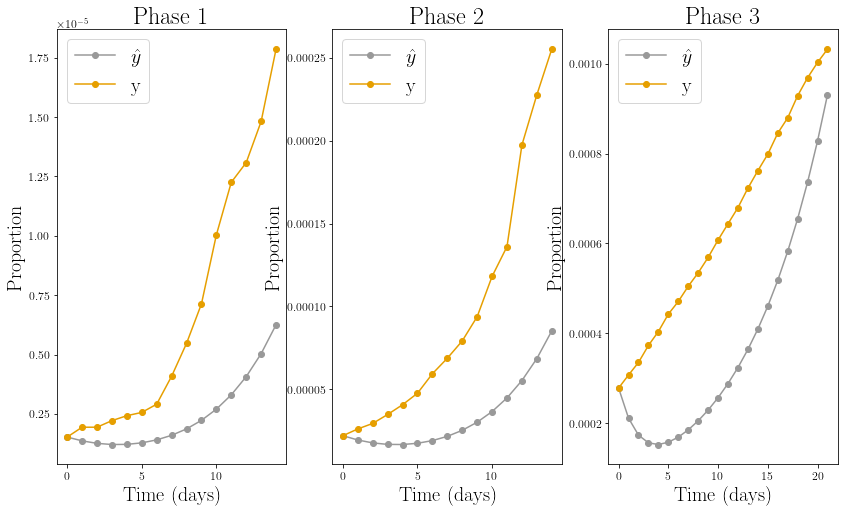

In [16]:
modelPhases = []
fig1,ax=plt.subplots(1,3,figsize=(14,8))
for i,phase in enumerate(critPhaseCases):
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    # get initial conditions   
    if i == 0:
        initConditions = {'R':0,
                      'I':df['I'][0]}
    else:
        initConditions = {'R':modelPhases[i-1].solution['R'][-1],
                      'I':df['I'][0]}
    
    modelPhases.append(mySIWIRMModel.sewirm(data=df,
                    initConditions=initConditions))
    
    modelPhases[i].run()
    
    # Plotting ----------------------
    ax[phase['phase']-1] = modelPhases[i].plot(ax[phase['phase']-1])
    ax[phase['phase']-1].set_title(f"Phase {i+1}") 